In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import cluster, metrics, datasets

import pickle

## 1. Read cleaned data from previous modeling process

In [2]:
position_model_1 = pd.read_csv("/Users/marcus/Documents/Projects/Final/Final_Project_NBA_Classifier/data/position_model_1.csv")
position_model = pd.read_csv("/Users/marcus/Documents/Projects/Final/Final_Project_NBA_Classifier/data/position_model.csv")
clean_nba = pd.read_csv("/Users/marcus/Documents/Projects/Final/Final_Project_NBA_Classifier/data/clean_nba.csv")

In [3]:
position_model_1.head()

,Pos,2PA,FTA,ORB,DRB,AST,STL,BLK,TOV,2P_3-10,2P%_0-3,3P%,2P%_asst,3P%_asst,Corner3%_3PA
0,C,13.7,5.8,6.0,10.9,4.2,1.5,1.9,2.7,0.397,0.743,0.333,0.670,1.000,0.333
1,PF,15.7,7.7,3.6,11.3,7.4,1.7,1.9,4.1,0.301,0.726,0.143,0.715,0.500,0.571
2,C,17.3,5.2,2.8,7.9,3.5,1.0,2.4,2.0,0.129,0.719,0.389,0.567,0.951,0.185
3,SG,10.4,2.9,0.7,5.9,7.0,1.3,0.6,4.2,0.173,0.523,0.346,0.192,0.913,0.188
4,SG,7.2,2.9,0.5,5.0,3.4,0.7,0.1,2.1,0.179,0.711,0.404,0.600,0.982,0.255


## 2. X/Y Split, Scalinf and save scaler as pickle

In [4]:
X = position_model_1.drop(["Pos"], axis=1)
y = position_model_1['Pos']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data = X_scaled,columns = X.columns)
pickle.dump(scaler, open("/Users/marcus/Documents/Projects/Final/Final_Project_NBA_Classifier/pickle/scaler", "wb"))

## 3. Defining functions for clustering

In [11]:
def kmeans(reduced_data, n_clusters):
    """
    performs kmeans clustering and returns labels, centroids, inertia, and silhouette score
    """
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    kmeans = kmeans.fit(reduced_data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    inertia = kmeans.inertia_
    sil_score = metrics.silhouette_score(reduced_data, kmeans.labels_, metric='euclidean')

    data_dictionary = {
        "labels": labels,
        "centroids": centroids,
        "inertia" : inertia,
        "silhouette_score": sil_score
    }
    pickle.dump(kmeans, open("/Users/marcus/Documents/Projects/Final/Final_Project_NBA_Classifier/pickle/kmeans", "wb"))

    return data_dictionary

def find_best_cluster(data,a,b):
    """
    plots and finds the best silhouette score for range(a,b)
    """
    scores = []
    for i in range(a,b):
        i_clusters = kmeans(data, i)
        sil_score_i = i_clusters['silhouette_score']
        scores.append(sil_score_i)

    sns.set_context('poster', font_scale=1)
    plt.plot(range(a,b), scores)
    plt.xticks([5, 6, 7, 8, 9, 10, 11, 12])
    plt.title("""Measuring Silhouette Score to Find Best Cluster""")
    print ("best silhouette score:", np.max(scores))
    
def feature_importance(cluster_data, league_data):
    """
    takes reduced data,
    performs Principal Component Analysis,
    returns feature importance dataframe
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)

    pca = PCA(n_components=2)
    PCA_reduced_df = pca.fit(scaled_data).transform(scaled_data)

    features = pd.DataFrame(zip(cluster_data.columns, pca.components_[0], np.mean(cluster_data), np.mean(league_data)),
        columns=['Feature', 'Importance', 'Cluster Average', 'League Average']).sort_values('Importance', ascending=False).head(10)

    return features

## 4. Clustering

Find best cluster

best silhouette score: 0.15795618827181926


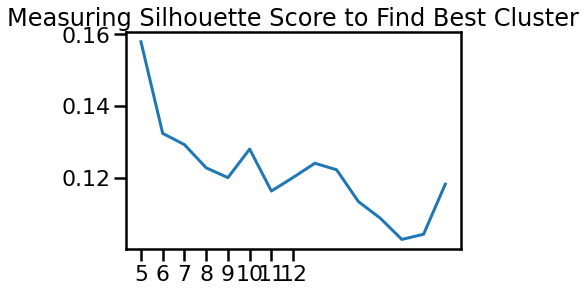

In [12]:
find_best_cluster(X_scaled,5,20)

Run k_means with 10 clusters

In [13]:
kmeans = kmeans(X_scaled, 10)

In [14]:
# Assign labels
clean_nba['Cluster'] = kmeans['labels']

# Print silhouette score
print ("silhouette score:", kmeans['silhouette_score'])

silhouette score: 0.12801684756143905


## 5. Analyzing clusters

Feature importance

In [19]:
list_clusters = [0,1,2,3,4,5,6,7,8,9]

for i in list_clusters:
    mask = (clean_nba['Cluster'] == i)
    cluster_data = clean_nba[mask].drop(['player_new', 'Pos','Tm', 'Cluster'], axis=1)
    league_data = clean_nba.drop(['player_new', 'Pos','Tm', 'Cluster'], axis=1)
    print("Cluster number is ", i)
    print(feature_importance(cluster_data, league_data).reset_index().drop('index', axis=1))

Cluster number is  0
          Feature  Importance  Cluster Average  League Average
0            DRtg    0.241347       108.461538      111.160083
1  avg_shoot_dist    0.226671         4.038462       13.785031
2        2P_10-16    0.195314         0.061692        0.078470
3          3P_FGA    0.168004         0.014769        0.396848
4         2P_3-10    0.166226         0.240115        0.162189
5       2P%_16-3P    0.162876         0.284885        0.346347
6              PF    0.155042         6.169231        4.393139
7    Corner3%_3PA    0.146547         0.170500        0.245435
8             TOV    0.121001         2.542308        2.631393
9        2P_16-3P    0.119273         0.035231        0.066044
Cluster number is  1
  Feature  Importance  Cluster Average  League Average
0      2P    0.301067         5.500000        5.229938
1     2PA    0.297914        10.606061       10.008108
2  2P_FGA    0.272805         0.690879        0.603154
3      FG    0.246757         7.000000       

Distribution of traditional positions among clusters.

In [21]:
list_clusters = [0,1,2,3,4,5,6,7,8,9]

for i in list_clusters:
    mask = (clean_nba['Cluster'] == i)
    print("Cluster: ", i)
    print(clean_nba[mask]["Pos"].value_counts())
    print (len(clean_nba[mask].value_counts()))


Cluster:  0
C     23
PF     3
Name: Pos, dtype: int64
26
Cluster:  1
SF    10
SG     7
PG     7
PF     7
C      2
Name: Pos, dtype: int64
33
Cluster:  2
PG    44
SG    33
SF     6
PF     1
Name: Pos, dtype: int64
84
Cluster:  3
PF    34
SF    33
SG    26
C      5
PG     1
Name: Pos, dtype: int64
99
Cluster:  4
C     18
PF     9
SG     1
Name: Pos, dtype: int64
28
Cluster:  5
C     36
PF     5
SF     1
Name: Pos, dtype: int64
42
Cluster:  6
SF    16
PF    10
SG     4
PG     3
Name: Pos, dtype: int64
33
Cluster:  7
SG    30
PF    30
SF    19
C      6
PG     3
Name: Pos, dtype: int64
88
Cluster:  8
PG    25
SG     7
SF     6
PF     4
Name: Pos, dtype: int64
42
Cluster:  9
C    6
Name: Pos, dtype: int64
6


## 6. Naming clusters

In [22]:
clean_nba['Cluster_name'] = clean_nba['Cluster'].map({0: 'Just_Big',
                                 1: 'Def Driving Shot Creator',
                                 2: 'Spot Up Facilitator',
                                 3: 'Spot Up Wing',
                                 4: 'Facilitating/Midrange Big',
                                 5: 'Sharp-Shooting Big',
                                 6: 'Rotational',
                                 7: 'Midrange Shooter',
                                 8: 'Attacking Facilitator',
                                 9: 'Dirty-Work'})


## 7. Save player data with assigned clusters

In [23]:
clean_nba.to_csv(r'/Users/marcus/Documents/Projects/Final/Final_Project_NBA_Classifier/data/clean_nba_cluster.csv', index = False)